In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
class Portfolio:
    def __init__(self, tickers, weights, start, end, index, period):

        self.tickers = tickers
        self.weights = np.array(weights)
        self.start = start
        self.end = end
        self.index = index
        self.period = period
        self.data = self._clean_data()
    
    def _clean_data(self):

        returns = {}
        for ticker in self.tickers:
            data = yf.download(ticker, start=self.start, end=self.end, interval=self.period)
            data['Return'] = data['Adj Close'].pct_change()
            returns[ticker] = data['Return']

        index_data = yf.download(self.index, start=self.start, end=self.end, interval=self.period)
        index_data['Market Return'] = index_data['Adj Close'].pct_change()

        returns_df = pd.DataFrame(returns)
        returns_df['Market'] = index_data['Market Return']
        returns_df = returns_df.dropna()
        return returns_df

    def weighted_returns(self):

        weighted_returns = (self.data[self.tickers] * self.weights).sum(axis=1)
        return weighted_returns

    def regression_model(self):

        weighted_returns = self.weighted_returns()

        market_returns = self.data['Market']

        X = market_returns.values.reshape(-1, 1)
        Y = weighted_returns.values
        model = LinearRegression()
        model.fit(X, Y)
        beta = model.coef_[0]
        alpha = model.intercept_

        plt.figure(figsize=(10, 6))
        plt.scatter(market_returns, weighted_returns, label="Observed Returns", alpha=0.7, color='blue')
        plt.plot(market_returns, model.predict(X), color='red', label=f"Regression Line: Y = {beta:.2f}x + {alpha:.4f}")
        plt.title("Portfolio Regression vs. Market Returns")
        plt.xlabel("Market Returns")
        plt.ylabel("Portfolio Returns")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def mesure(self, risk_free_rate=0.03):

        weighted_returns = self.weighted_returns()
        market_returns = self.data['Market']

        avg_portfolio_return = weighted_returns.mean()
        avg_market_return = market_returns.mean()
        std_dev_portfolio = weighted_returns.std()

        cov_matrix = np.cov(weighted_returns, market_returns)
        beta_portfolio = cov_matrix[0, 1] / cov_matrix[1, 1]

        sharpe_ratio = (avg_portfolio_return - risk_free_rate) / std_dev_portfolio

        treynor_ratio = (avg_portfolio_return - risk_free_rate) / beta_portfolio

        jensens_alpha = avg_portfolio_return - (risk_free_rate + beta_portfolio * (avg_market_return - risk_free_rate))

        downside_returns = weighted_returns[weighted_returns < risk_free_rate]
        downside_deviation = np.sqrt(np.mean(downside_returns**2))
        sortino_ratio = (avg_portfolio_return - risk_free_rate) / downside_deviation

        active_returns = weighted_returns - market_returns
        tracking_error = active_returns.std()
        information_ratio = active_returns.mean() / tracking_error

        return sharpe_ratio, treynor_ratio, jensens_alpha, sortino_ratio, information_ratio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


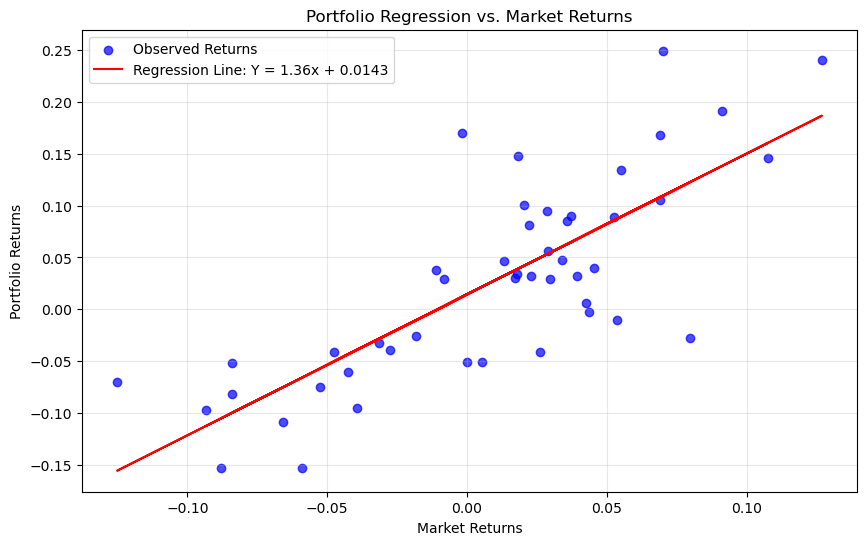

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
weights = [0.2, 0.3, 0.1, 0.2, 0.2]  

portfolio = Portfolio(tickers, weights, "2019-01-01", "2023-01-01", "^GSPC", "1mo")
portfolio_returns = portfolio.weighted_returns()
portfolio.regression_model()

In [4]:
measures = portfolio.mesure()
print("Sharpe Ratio:", measures[0])
print("Treynor Ratio:", measures[1])
print("Jensen's Alpha:", measures[2])
print("Sortino Ratio:", measures[3])
print("Information Ratio:", measures[4])

Sharpe Ratio: -0.03532588461286065
Treynor Ratio: -0.0025195788483310965
Jensen's Alpha: 0.025089137036865727
Sortino Ratio: -0.048367844279166745
Information Ratio: 0.2758914752118836
